In [2]:
#####Von Mises Regression model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from numpy.random import *
from scipy import optimize
import seaborn as sns
import time

#np.random.seed(98537)

In [3]:
####データの発生####
##データの設定
k = 10
N = 100000

##説明変数の生成
k1 = 4; k2 = 5; k3 = 6
x1 = np.array(np.random.random(N*k1)).reshape((N, k1))
x2 = np.zeros((N, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, N)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), N)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x = np.concatenate((np.repeat(1, N)[:, np.newaxis], x1, x2, x3), axis=1)
k = x.shape[1]

(array([ 7698.,  2554.,  1459.,  1903.,  3168.,  5971., 12020., 20826.,
        25803., 18598.]),
 array([-3.14145881e+00, -2.51316181e+00, -1.88486481e+00, -1.25656781e+00,
        -6.28270811e-01,  2.61887266e-05,  6.28323189e-01,  1.25662019e+00,
         1.88491719e+00,  2.51321419e+00,  3.14151119e+00]),
 <a list of 10 Patch objects>)

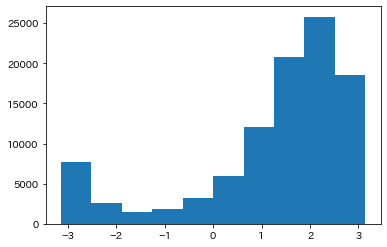

In [4]:
##応答変数の生成
#パラメータの設定
beta0 = np.random.uniform(0.75, 1.5, 1)
beta1 = np.random.normal(0, 0.75, k-1)
beta = np.append(beta0, beta1)
kappa = np.random.uniform(2.0, 4.0, 1)
betat = beta.copy(); kappat = kappa.copy()

#フォンミーゼス分布から円周データを生成
mu = 2*np.arctan(np.dot(x, beta))
y = np.random.vonmises(mu, kappa, N)
plt.hist(y)

In [5]:
##Von Mises Regression modelのパラメータを推定するための関数
#Von Mises Regression modelの対数尤度関数
def loglike(theta, y, x, N, index1, index2):
    
    #パラメータの設定
    beta = theta[index1]
    kappa = np.exp(theta[index2])
    
    #対数尤度の和を計算
    mu = 2*np.arctan(np.dot(x, beta))
    LL = -N*np.log(2*np.pi*scipy.special.i0(kappa)) + kappa*np.sum(np.cos(y - mu))
    return -LL

In [19]:
#Von Mises Regression modelの対数尤度関数の勾配ベクトル
def dloglike(theta, y, x, N, index1, index2):
    
    #パラメータの設定
    beta = theta[index1]
    kappa = np.exp(theta[index2])

    #回帰ベクトルの対数尤度の勾配ベクトル
    beta_mu = np.dot(x, beta)
    mu = 2*np.arctan(beta_mu)
    LLd1 = np.sum(kappa * (np.sin(y - mu).reshape(N, 1)) * (2 * (x / (1 + np.power(beta_mu.reshape(N, 1), 2)))), axis=0)
    
    #分散パラメータの対数尤度の勾配
    h = 1e-4
    LLd2 = (LL_kappa(kappa+h, mu, y, x, N) - LL_kappa(kappa-h, mu, y, x, N)) / (2*h)
    
    #勾配ベクトルの戻り値
    LLd = -np.append(LLd1, LLd2)
    return LLd

In [20]:
#分散パラメータの推定用の対数尤度関数
def LL_kappa(kappa, mu, y, x, N):
    LL = -N*np.log(2*np.pi*scipy.special.i0(kappa)) + kappa*np.sum(np.cos(y - mu))
    return LL 

In [21]:
##準ニュートン法で対数尤度を最大化
while True:
    #初期値の設定
    index1 = np.arange(k); index2 = k
    beta = np.append(1, np.random.normal(0, 0.25, k-1))
    kappa = np.random.uniform(0, 1.0, 1)
    theta = np.append(beta, kappa)

    #対数尤度を最大化
    res = optimize.minimize(loglike, theta, jac=dloglike, method='BFGS', args=(y, x, N, index1, index2), 
                            options={"gtol": 0.1, "disp":False})
    if res.success==True:
        break

In [17]:
##推定されたパラメータの確認と適合度
#推定されたパラメータと真のパラメータの比較
theta = res.x   #推定されたパラメータ
hessian = res.hess_inv   #ヘッシアンの逆行列
LL = -res.fun   #最大化された対数尤度
LLbest = -loglike(np.append(betat, np.log(kappat)), y, x, N, index1, index2)   #真値での対数尤度
print(np.round(np.array([LL, LLbest]), 3))
print(np.round(np.array([theta[index1], betat]), 3))
print(np.round(np.append(np.exp(theta[index2]), kappat), 3))

[-121019.796 -121025.625]
[[ 1.386  0.659 -1.178  0.177 -0.712  1.455 -0.393  0.361  0.014  0.474
   1.019  0.44   0.094 -0.888  0.214]
 [ 1.36   0.663 -1.173  0.196 -0.707  1.461 -0.394  0.363  0.011  0.478
   1.029  0.437  0.099 -0.872  0.224]]
[2.176 2.164]


In [18]:
#適合度の確認
t_value = theta / np.sqrt(np.diag(hessian))   #t値
AIC = -2*LL + 2*(k+1)   #AIC
BIC = -2*LL + np.log(N)*(k+1)   #BIC
print(np.round(t_value, 3))
print(np.round(np.array([LL, AIC, BIC]), 3))

[ 77.144  54.403 -95.854  14.421 -59.181 144.016 -55.71   43.156   2.015
  56.844  51.452  29.148   6.377 -67.108  15.786 145.719]
[-121019.796  242071.592  242223.799]
